In [3]:
#Добавляем путь к нашей модели чтобы в дальнейшем ее импортировать
import sys
sys.path.append('/Users/rustam/Documents/GitHub/python_exam_academy/Models')

In [4]:
# Для того, чтобы не выводились предупреждения и информация о логах

import logging
import os
import warnings


logging.getLogger('prophet').disabled = True
warnings.filterwarnings('ignore')

class suppress_stdout_stderr(object):

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [5]:
# Подключаем библиотеки

import math 
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time

import holidays
import prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import LinearRegression as linreg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Importing plotly failed. Interactive plots will not work.


In [6]:
from google.oauth2 import service_account
project_id = 'kolesa-android-app'
credentials = '/Users/rustam/Kolesa/kolesa-android-app-715adc9bdf26.json'
credentials = service_account.Credentials.from_service_account_file(credentials)

In [7]:
q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset`
ORDER BY 1"""

In [8]:
data = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')

Downloading: 100%|█████████████████████████████████████████████████████████████|


**Загружайте данные из csv**

In [9]:
#data = pd.read_csv('data.csv') 

In [10]:
data

,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435
...,...,...
1091,2022-12-27,17042
1092,2022-12-28,16195
1093,2022-12-29,14966
1094,2022-12-30,13070


In [11]:
data.columns = ['ds','y']
data.index = pd.to_datetime(data['ds'])
data['ds'] = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


In [12]:
cleaned_data = data.replace(10000000, (15767 + 15341) // 2)

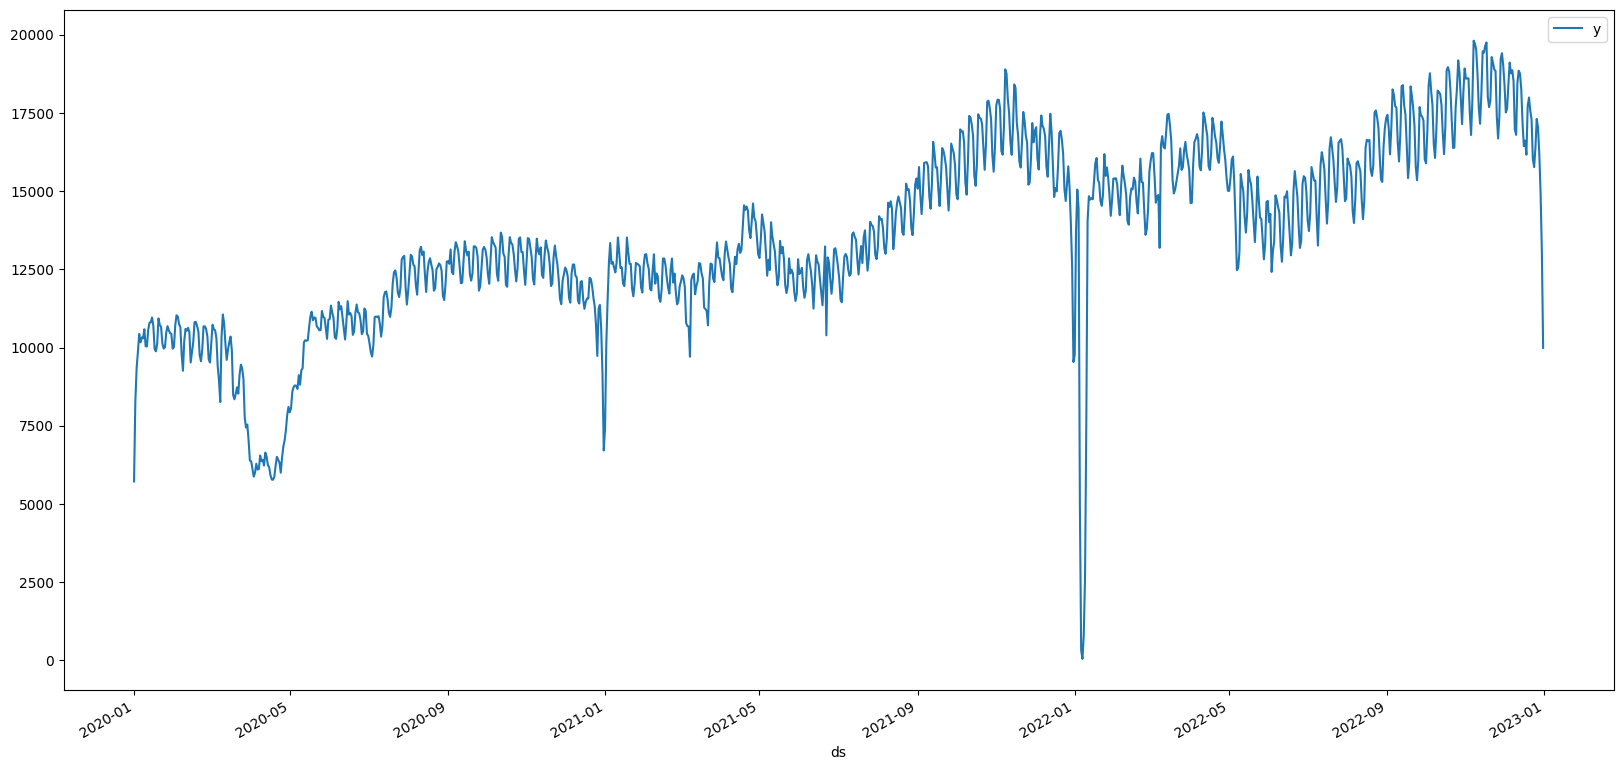

In [13]:
cleaned_data.plot(x="ds",y="y",kind="line", figsize=(20, 10));

In [14]:
date_start = '2022-01-05'
date_end = '2022-01-10'
cleaned_data.loc[(cleaned_data['ds'] >= date_start) & (cleaned_data['ds'] <= date_end), 'y'] = 14000
date_start = '2020-03-01'
date_end = '2020-06-01'
cleaned_data.loc[(cleaned_data['ds'] >= date_start) & (cleaned_data['ds'] <= date_end), 'y'] = 11000

<Axes: xlabel='ds'>

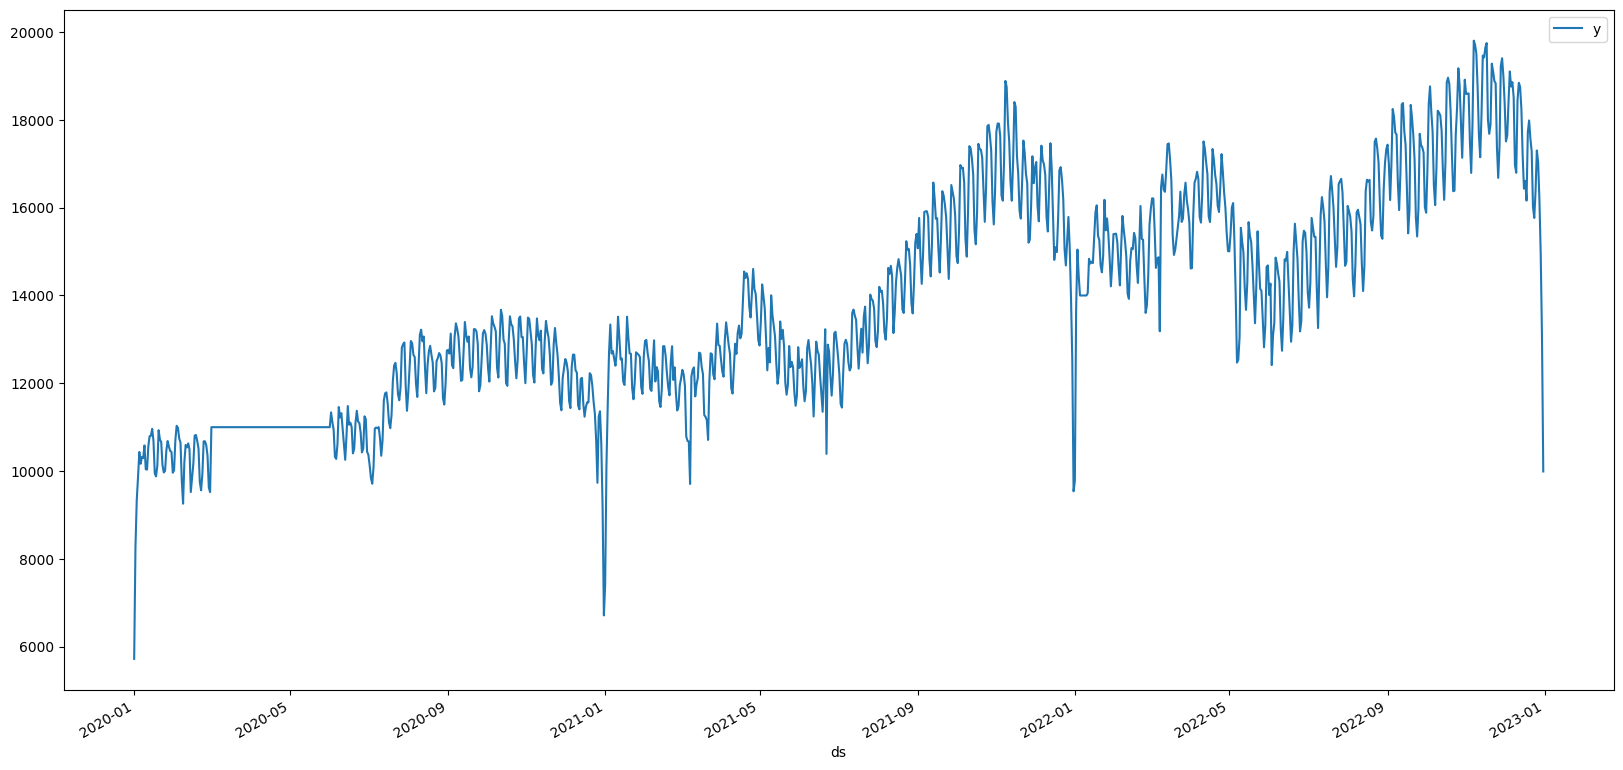

In [15]:
cleaned_data.plot(x="ds",y="y",kind="line", figsize=(20, 10))

In [16]:
cleaned_data

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435
...,...,...
2022-12-27,2022-12-27,17042
2022-12-28,2022-12-28,16195
2022-12-29,2022-12-29,14966


In [17]:
# Разделение даты на год, месяц и день
cleaned_data['year'] = cleaned_data['ds'].dt.year
cleaned_data['month'] = cleaned_data['ds'].dt.month
cleaned_data['day'] = cleaned_data['ds'].dt.day

# Разделение данных на признаки (X) и целевую переменную (y)
#X = cleaned_data[['year', 'month', 'day']].values
X = np.array(cleaned_data[['year','month','day']], dtype=float)
y = np.array(cleaned_data['y'], dtype=float)

# Масштабирование данных (опционально, но может улучшить производительность модели)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Инициализация и обучение модели
model = linreg.LinearRegression(fit_intercept=True,
                             lr=0.01,
                             max_iter=10000,
                             sgd=True,
                             n_sample=32,
                             regularization=None,
                             alpha=0.0)
l = model.fit(X_scaled, y).get_losses()

# Прогнозирование на будущие даты
future_dates = pd.date_range(start='2020-01-06', end='2023-12-31')  
future_year = future_dates.year.values.reshape(-1, 1)
future_month = future_dates.month.values.reshape(-1, 1)
future_day = future_dates.day.values.reshape(-1, 1)
X_future = scaler.transform(np.hstack((future_year, future_month, future_day)))
y_pred = model.predict(X_future)

# Вывод результатов прогнозирования
future_predictions = pd.DataFrame({'ds': future_dates, 'predicted_y': y_pred})
print(future_predictions)

             ds   predicted_y
0    2020-01-06   9759.670136
1    2020-01-07   9762.290492
2    2020-01-08   9764.910847
3    2020-01-09   9767.531203
4    2020-01-10   9770.151558
...         ...           ...
1451 2023-12-27  20023.516689
1452 2023-12-28  20026.137044
1453 2023-12-29  20028.757400
1454 2023-12-30  20031.377755
1455 2023-12-31  20033.998111

[1456 rows x 2 columns]


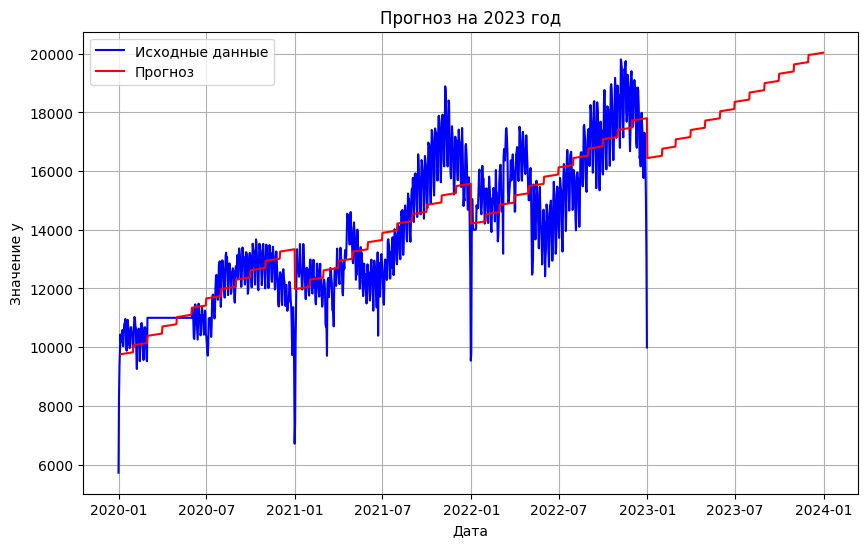

In [18]:
# Отображение результатов прогнозирования на графике
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['ds'], cleaned_data['y'], label='Исходные данные', color='blue')
plt.plot(future_predictions['ds'], future_predictions['predicted_y'], label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Значение y')
plt.title('Прогноз на 2023 год')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Разделение даты на год, месяц и день
cleaned_data['year'] = cleaned_data['ds'].dt.year
cleaned_data['month'] = cleaned_data['ds'].dt.month
cleaned_data['day'] = cleaned_data['ds'].dt.day
cleaned_data['weekday'] = cleaned_data['ds'].dt.weekday

# Разделение данных на признаки (X) и целевую переменную (y)
#X = cleaned_data[['year', 'month', 'day']].values
X = np.array(cleaned_data[['year','month','day','weekday']], dtype=float)
y = np.array(cleaned_data['y'], dtype=float)

# Масштабирование данных (опционально, но может улучшить производительность модели)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Инициализация и обучение модели
model = linreg.LinearRegression(fit_intercept=True,
                             lr=0.01,
                             max_iter=10000,
                             sgd=True,
                             n_sample=32,
                             regularization=None,
                             alpha=0.0)
l = model.fit(X_scaled, y).get_losses()

# Прогнозирование на будущие даты
future_dates = pd.date_range(start='2020-01-06', end='2023-12-31')  
future_year = future_dates.year.values.reshape(-1, 1)
future_month = future_dates.month.values.reshape(-1, 1)
future_day = future_dates.day.values.reshape(-1, 1)
future_weekday = future_dates.weekday.values.reshape(-1, 1)
X_future = scaler.transform(np.hstack((future_year, future_month, future_day,future_weekday)))
y_pred = model.predict(X_future)

# Вывод результатов прогнозирования
future_predictions = pd.DataFrame({'ds': future_dates, 'predicted_y': y_pred})
print(future_predictions)

             ds   predicted_y
0    2020-01-06  10493.403347
1    2020-01-07  10276.257033
2    2020-01-08  10059.110719
3    2020-01-09   9841.964405
4    2020-01-10   9624.818092
...         ...           ...
1451 2023-12-27  20197.439171
1452 2023-12-28  19980.292857
1453 2023-12-29  19763.146544
1454 2023-12-30  19546.000230
1455 2023-12-31  19328.853916

[1456 rows x 2 columns]


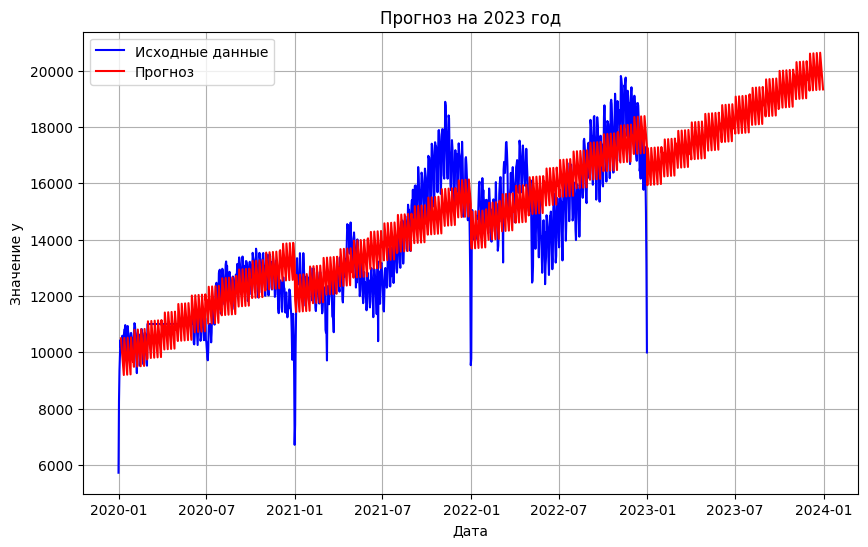

In [20]:
# Отображение результатов прогнозирования на графике
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['ds'], cleaned_data['y'], label='Исходные данные', color='blue')
plt.plot(future_predictions['ds'], future_predictions['predicted_y'], label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Значение y')
plt.title('Прогноз на 2023 год')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
cleaned_data

,ds,y,year,month,day,weekday
ds,,,,,,
2020-01-01,2020-01-01,5721,2020,1,1,2
2020-01-02,2020-01-02,8274,2020,1,2,3
2020-01-03,2020-01-03,9344,2020,1,3,4
2020-01-04,2020-01-04,9864,2020,1,4,5
2020-01-05,2020-01-05,10435,2020,1,5,6
...,...,...,...,...,...,...
2022-12-27,2022-12-27,17042,2022,12,27,1
2022-12-28,2022-12-28,16195,2022,12,28,2
2022-12-29,2022-12-29,14966,2022,12,29,3


In [24]:
result = future_predictions.tail(365)
result

,ds,predicted_y
1091,2023-01-01,15928.167464
1092,2023-01-02,17241.700747
1093,2023-01-03,17024.554434
1094,2023-01-04,16807.408120
1095,2023-01-05,16590.261806
...,...,...
1451,2023-12-27,20197.439171
1452,2023-12-28,19980.292857
1453,2023-12-29,19763.146544
1454,2023-12-30,19546.000230


In [35]:
forecast_results = pd.read_excel('forecast_results.xlsx')
forecast_results

,ds,yhat,linreg,destree
0,2023-01-01,11370.537810,14962.140000,14962.140000
1,2023-01-02,16464.051658,15811.500000,15811.500000
2,2023-01-03,16329.229286,15618.500000,15618.500000
3,2023-01-04,16385.473966,15672.328767,15672.328767
4,2023-01-05,16252.706511,15672.328767,15672.328767
...,...,...,...,...
360,2023-12-27,18101.831464,18397.208333,18397.208333
361,2023-12-28,17760.794867,18397.208333,18397.208333
362,2023-12-29,17023.925655,16990.250000,16990.250000
363,2023-12-30,16714.606881,16990.250000,16990.250000


In [36]:
# Добавление столбца из другого источника к датафрейму forecast_results
forecast_results['linreg'] = result['predicted_y'].values

# Сохранение обновленного датафрейма с дополнительным столбцом в тот же файл
forecast_results.to_excel('forecast_results.xlsx', index=False)

In [37]:
result['predicted_y']

1091    15928.167464
1092    17241.700747
1093    17024.554434
1094    16807.408120
1095    16590.261806
            ...     
1451    20197.439171
1452    19980.292857
1453    19763.146544
1454    19546.000230
1455    19328.853916
Name: predicted_y, Length: 365, dtype: float64

In [38]:
forecast_results

,ds,yhat,linreg,destree
0,2023-01-01,11370.537810,15928.167464,14962.140000
1,2023-01-02,16464.051658,17241.700747,15811.500000
2,2023-01-03,16329.229286,17024.554434,15618.500000
3,2023-01-04,16385.473966,16807.408120,15672.328767
4,2023-01-05,16252.706511,16590.261806,15672.328767
...,...,...,...,...
360,2023-12-27,18101.831464,20197.439171,18397.208333
361,2023-12-28,17760.794867,19980.292857,18397.208333
362,2023-12-29,17023.925655,19763.146544,16990.250000
363,2023-12-30,16714.606881,19546.000230,16990.250000
